# Modeling for Income Prediction Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool

import optuna
from optuna.samplers import TPESampler

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import TargetEncoder

from xgboost import plot_importance

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 경로
path = "data/cramer_preprocessed.csv"
submission_path = "data/sample_submission.csv"
df = pd.read_csv(path)
submission_df = pd.read_csv(submission_path)

In [3]:
# 전체 컬럼 개수 : 12
len(df.columns)

12

## 데이터 분리

In [4]:
# concat 했던 train, test 데이터셋 분리
train = df.loc[:19999]
test = df.loc[20000:]
train.shape, test.shape

((20000, 12), (10000, 12))

In [5]:
# target 컬럼 "income"
target = "income"
# 나머지 컬럼 features에 선언
features = df.drop(columns=target).columns

# validation 데이터셋 생성
train, val = train_test_split(train, train_size=0.7, random_state=42)

In [6]:
# train 데이터 나눠준다
X_train = train[features]
y_train = train[target]

# validation 데이터 나눠준다
X_val = val[features]
y_val = val[target]

# test 데이터 나눠준다
X_test = test[features]
y_test = test[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((14000, 11), (14000,), (6000, 11), (6000,), (10000, 11), (10000,))

In [7]:
# train 데이터 copy
X_train_no_enc = train[features].copy()

# validation 데이터 copy
X_val_no_enc = val[features].copy()

# test 데이터 copy
X_test_no_enc = test[features].copy()

### Target Encoding
- 머신 러닝 모델의 출력이 숫자 (회귀)일 때만 범주형 feature에 사용

- 각 범주에 대한 평균 목표값 계산 → 인코딩 하기 위해 범주형 값이 갖는 범주에 해당하는 백분율 대체
- 각 카테고리의 값을 학습 데이터의 target 값의 평균값으로 설정한다
- 데이터 관측치가 많아야 한다
- 과적합의 원인이 될 수 있다
- references
    - https://conanmoon.medium.com/%EB%8D%B0%EC%9D%B4%ED%84%B0%EA%B3%BC%ED%95%99-%EC%9C%A0%EB%A7%9D%EC%A3%BC%EC%9D%98-%EB%A7%A4%EC%9D%BC-%EA%B8%80%EC%93%B0%EA%B8%B0-%EC%9D%BC%EA%B3%B1%EB%B2%88%EC%A7%B8-%EC%9D%BC%EC%9A%94%EC%9D%BC-7a40e7de39d4
    - https://velog.io/@seungwoong12/encoding

In [8]:
# Scikit-learn TargetEncoder 사용
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html
# Scikit-learn 버전 높아야 사용 가능 (업데이트 필요)

# 범주형 변수 목록 cat_features에 선언
cat_features = df.select_dtypes(exclude=np.number).columns.tolist()

# smooth="auto", cv=5로 TargetEncoder 객체 생성
te = TargetEncoder(target_type="continuous", smooth="auto", cv=5, random_state=42)

for cat_feature in cat_features:
    # Train 데이터로 fit_transform 해준다
    X_train[[cat_feature]] = te.fit_transform(X_train[[cat_feature]], y_train)
    X_val[[cat_feature]] = te.transform(X_val[[cat_feature]])
    X_test[[cat_feature]] = te.transform(X_test[[cat_feature]])

## Baseline 모델 생성

In [9]:
# 선형회귀 모델로 Baseline 모델 생성
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [10]:
# Baseline 모델 절편, 결정 계수 확인

print("Intercept: ", lr.intercept_)
print("Coefficients:")
list(zip(X_train, lr.coef_))

Intercept:  -816.5550401216223
Coefficients:


[('age', 1.092088082661836),
 ('gender', 0.5195467370541507),
 ('education_status', 0.07088659596718268),
 ('working_week (yearly)', 3.4141391100580947),
 ('occupation_status', 0.747997489682108),
 ('race', -0.38655681903657235),
 ('hispanic_origin', 0.45166068593311137),
 ('household_summary', -0.008398213916912464),
 ('citizenship', 0.3875410502199062),
 ('tax_status', 0.015147235735867848),
 ('income_status', 0.382437015983877)]

In [11]:
def baseline_model(model_name, model):
    baseline_results = []

    print(f"\n====== Baseline Model : {model_name} ======")
    
    # 모델 생성 및 훈련
    # model.fit(X_train, y_train)

    # Baseline 모델로 train, validation, test 데이터셋 예측
    y_train_pred_lr = model.predict(X_train)
    y_val_pred_lr = model.predict(X_val)

    # Baseline 모델의 MAE, MSE, RMSE, RMSLE, R2 score 확인
    base_meanAbErr = metrics.mean_absolute_error(y_val, y_val_pred_lr)
    base_meanSqErr = metrics.mean_squared_error(y_val, y_val_pred_lr)
    base_rootMeanSqErr = metrics.mean_squared_error(y_val, y_val_pred_lr, squared=False)


    # 결과를 리스트에 저장
    baseline_results.append({"Model" : model_name,
                             "MAE" : '{:.2f}'.format(base_meanAbErr),
                             "MSE" : '{:.2f}'.format(base_meanSqErr),
                             "RMSE" : '{:.2f}'.format(base_rootMeanSqErr),
                             "R2 Score" : '{:.2f}'.format(model.score(X_val, y_val))})
    
    # 결과 리스트를 DataFrame으로 변환
    baseline_df = pd.DataFrame(baseline_results)
    
    return baseline_df

In [12]:
baseline_model("Linear Regression", lr)


====== Baseline Model : Linear Regression ======


,Model,MAE,MSE,RMSE,R2 Score
0,Linear Regression,369.48,362055.58,601.71,0.24


## 머신러닝 모델링

### 하이퍼 파라미터 튜닝 전 모델 생성

In [13]:
model_list = ["lr_model", "dt_model", "rf_model", "cat_model", "lgbm_model", "xgb_model"]

lr_model = LinearRegression()
dt_model = DecisionTreeRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)
cat_model = CatBoostRegressor(random_state=42)
lgbm_model = LGBMRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42)

models = [
    ("Linear Regression", LinearRegression()),
    ("Decision Tree", DecisionTreeRegressor(random_state=42)),
    ("Random Forest", RandomForestRegressor(random_state=42)),
    ("CatBoost", CatBoostRegressor(random_state=42)),
    ("LightGBM", LGBMRegressor(random_state=42)),
    ("XGBoost", XGBRegressor(random_state=42))
]

In [14]:
def model_list(models, when="Before"):
    models_results = []

    for model_name, model in models:

        # 모델 생성 및 훈련
        # 트리 기반 모델들은 각 변수의 information gain을 기반으로 판단하기 때문에 굳이 스케일링 해줄 필요가 없다

        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        # 모델의 MAE, MSE, RMSE, RMSLE, R2 score 확인
        meanAbErr = metrics.mean_absolute_error(y_val, y_val_pred)
        meanSqErr = metrics.mean_squared_error(y_val, y_val_pred)
        rootMeanSqErr = metrics.mean_squared_error(y_val, y_val_pred, squared=False)


        # 결과를 리스트에 저장
        models_results.append({"Model" : model_name,
                                "MAE" : '{:.2f}'.format(meanAbErr),
                                "MSE" : '{:.2f}'.format(meanSqErr),
                                "RMSE" : '{:.2f}'.format(rootMeanSqErr),
                                "R2 Score" : '{:.2f}'.format(model.score(X_val, y_val))})
    
    # 결과 리스트를 DataFrame으로 변환
    models_df = pd.DataFrame(models_results)

    print(f"\n====== Models {when} Hyper Parameter Tuning ======")
    
    return models_df.sort_values(by=["RMSE", "R2 Score"], ascending=[True, False]).reset_index(drop=True)

In [15]:
model_list(models)

Learning rate set to 0.062125
0:	learn: 696.5674660	total: 139ms	remaining: 2m 18s
1:	learn: 687.8345506	total: 141ms	remaining: 1m 10s
2:	learn: 680.1998000	total: 144ms	remaining: 47.8s
3:	learn: 672.9820101	total: 146ms	remaining: 36.4s
4:	learn: 666.5116267	total: 150ms	remaining: 29.8s
5:	learn: 660.8718229	total: 154ms	remaining: 25.5s
6:	learn: 655.6356643	total: 158ms	remaining: 22.4s
7:	learn: 651.0630157	total: 161ms	remaining: 20s
8:	learn: 647.2206951	total: 164ms	remaining: 18s
9:	learn: 643.8189238	total: 167ms	remaining: 16.5s
10:	learn: 640.3648808	total: 171ms	remaining: 15.4s
11:	learn: 637.6403431	total: 174ms	remaining: 14.3s
12:	learn: 634.7863226	total: 177ms	remaining: 13.4s
13:	learn: 632.0339960	total: 179ms	remaining: 12.6s
14:	learn: 629.9218802	total: 184ms	remaining: 12.1s
15:	learn: 627.7164569	total: 187ms	remaining: 11.5s
16:	learn: 625.9156953	total: 189ms	remaining: 10.9s
17:	learn: 624.0772962	total: 192ms	remaining: 10.5s
18:	learn: 622.7767823	total

84:	learn: 595.8364351	total: 409ms	remaining: 4.4s
85:	learn: 595.6686826	total: 413ms	remaining: 4.39s
86:	learn: 595.5640894	total: 417ms	remaining: 4.38s
87:	learn: 595.4263020	total: 423ms	remaining: 4.38s
88:	learn: 595.2058854	total: 425ms	remaining: 4.36s
89:	learn: 595.0451877	total: 428ms	remaining: 4.33s
90:	learn: 594.9448238	total: 430ms	remaining: 4.3s
91:	learn: 594.8617457	total: 433ms	remaining: 4.28s
92:	learn: 594.7689273	total: 437ms	remaining: 4.26s
93:	learn: 594.5563212	total: 440ms	remaining: 4.24s
94:	learn: 594.3403515	total: 442ms	remaining: 4.21s
95:	learn: 594.1273772	total: 445ms	remaining: 4.19s
96:	learn: 593.9973711	total: 447ms	remaining: 4.16s
97:	learn: 593.8709068	total: 450ms	remaining: 4.14s
98:	learn: 593.8179392	total: 454ms	remaining: 4.13s
99:	learn: 593.6109748	total: 456ms	remaining: 4.11s
100:	learn: 593.3837391	total: 459ms	remaining: 4.09s
101:	learn: 593.2100120	total: 462ms	remaining: 4.07s
102:	learn: 592.9383717	total: 465ms	remaining

,Model,MAE,MSE,RMSE,R2 Score
0,CatBoost,350.73,355385.99,596.14,0.26
1,LightGBM,347.45,356562.35,597.13,0.25
2,Linear Regression,369.48,362055.58,601.71,0.24
3,XGBoost,361.83,373628.25,611.25,0.22
4,Random Forest,358.85,382054.21,618.11,0.20
5,Decision Tree,492.19,747715.88,864.71,-0.57


In [16]:
# 범주형 변수를 따로 Target Encoding 거치지 않은 데이터셋으로 학습한 CatBoost 확인
def model_list2(models, when="Before"):
    models_results = []

    for model_name, model in models:

        if model_name in ["CatBoost", "CatBoost_tuned"]:

            cat_features = X_train_no_enc.select_dtypes(exclude=np.number).columns.tolist()

            X_train_pool = Pool(data=X_train_no_enc, label=y_train, cat_features=cat_features)
            X_val_pool = Pool(data=X_val_no_enc, label=y_val, cat_features=cat_features)

            # 모델 생성 및 훈련
            model.fit(X_train_pool, eval_set=X_val_pool, use_best_model=True)

            # Robust Scaling 거치지 않은 train 데이터를 바탕으로 예측
            y_train_pred_cat = model.predict(X_train_no_enc)
            y_val_pred_cat = model.predict(X_val_no_enc)

            # 모델의 MAE, MSE, RMSE, RMSLE, R2 score 확인
            meanAbErr_cat = metrics.mean_absolute_error(y_val, y_val_pred_cat)
            meanSqErr_cat = metrics.mean_squared_error(y_val, y_val_pred_cat)
            rootMeanSqErr_cat = metrics.mean_squared_error(y_val, y_val_pred_cat, squared=False)

            # 결과를 리스트에 저장
            models_results.append({"Model" : model_name,
                                    "MAE" : '{:.2f}'.format(meanAbErr_cat),
                                    "MSE" : '{:.2f}'.format(meanSqErr_cat),
                                    "RMSE" : '{:.2f}'.format(rootMeanSqErr_cat),
                                    "R2 Score" : '{:.2f}'.format(model.score(X_val_no_enc, y_val))})
        
        else:
            
            # 모델 생성 및 훈련
            model.fit(X_train, y_train)

            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)

            # 모델의 MAE, MSE, RMSE, RMSLE, R2 score 확인
            meanAbErr = metrics.mean_absolute_error(y_val, y_val_pred)
            meanSqErr = metrics.mean_squared_error(y_val, y_val_pred)
            rootMeanSqErr = metrics.mean_squared_error(y_val, y_val_pred, squared=False)

            # 결과를 리스트에 저장
            models_results.append({"Model" : model_name,
                                    "MAE" : '{:.2f}'.format(meanAbErr),
                                    "MSE" : '{:.2f}'.format(meanSqErr),
                                    "RMSE" : '{:.2f}'.format(rootMeanSqErr),
                                    "R2 Score" : '{:.2f}'.format(model.score(X_val, y_val))})
    
    # 결과 리스트를 DataFrame으로 변환
    models_df = pd.DataFrame(models_results)

    print(f"\n====== Models {when} Hyper Parameter Tuning ======")
    
    return models_df.sort_values(by=["RMSE", "R2 Score"], ascending=[True, False]).reset_index(drop=True)

In [17]:
model_list2(models)

Learning rate set to 0.077062
0:	learn: 694.6016981	test: 679.2604392	best: 679.2604392 (0)	total: 45ms	remaining: 45s
1:	learn: 684.5914100	test: 668.6240912	best: 668.6240912 (1)	total: 97.4ms	remaining: 48.6s
2:	learn: 675.9732927	test: 659.8066603	best: 659.8066603 (2)	total: 144ms	remaining: 48s
3:	learn: 668.1166748	test: 651.8043178	best: 651.8043178 (3)	total: 194ms	remaining: 48.4s
4:	learn: 661.5255589	test: 644.8508960	best: 644.8508960 (4)	total: 244ms	remaining: 48.6s
5:	learn: 656.3941048	test: 639.6503718	best: 639.6503718 (5)	total: 278ms	remaining: 46s
6:	learn: 651.0981461	test: 634.1200615	best: 634.1200615 (6)	total: 324ms	remaining: 45.9s
7:	learn: 646.1952454	test: 629.2888839	best: 629.2888839 (7)	total: 368ms	remaining: 45.6s
8:	learn: 641.9910716	test: 625.2074271	best: 625.2074271 (8)	total: 414ms	remaining: 45.6s
9:	learn: 639.0846022	test: 622.2529612	best: 622.2529612 (9)	total: 447ms	remaining: 44.2s
10:	learn: 636.2163018	test: 619.4076529	best: 619.40765

,Model,MAE,MSE,RMSE,R2 Score
0,CatBoost,346.84,353190.98,594.30,0.26
1,LightGBM,347.45,356562.35,597.13,0.25
2,Linear Regression,369.48,362055.58,601.71,0.24
3,XGBoost,361.83,373628.25,611.25,0.22
4,Random Forest,358.85,382054.21,618.11,0.20
5,Decision Tree,492.19,747715.88,864.71,-0.57


#### `CatBoost` 성능 비교
- 별도로 `Target Encoding` 거치지 않은 데이터셋으로 진행(`model_list2` 함수)한 `CatBoost`가 더 낮은 `RMSE` 기록

    - **596.14 vs 594.30** (CatBoost는 Target Encoding 실행하지 않은 데이터셋으로 진행)

### 하이퍼 파라미터 튜닝
- `RMSE`가 낮은 `CatBoost`, `LightGBM` 을 갖고 하이퍼 파라미터 튜닝
    - Baseline 모델인 `Linear Regression`의 `RMSE`보다 낮다 (599.30)
- `XGBoost`은 Baseline보다 `RMSE` 높지만 하이퍼파라이터 튜닝 시도

- `optuna` 활용
    - References : https://forecastegy.com/posts/xgboost-hyperparameter-tuning-with-optuna/


In [18]:
# optuna sampling seed 고정
sampler = TPESampler(seed=42)

#### CatBoost

In [19]:
def objective_cat(trial):
    params = {
        # "iterations": 1000,
        "iterations" : trial.suggest_int('n_estimators', 500, 4000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }
    cat_features = X_train_no_enc.select_dtypes(exclude=np.number).columns.tolist()

    X_train_pool = Pool(data=X_train_no_enc, label=y_train, cat_features=cat_features)
    X_val_pool = Pool(data=X_val_no_enc, label=y_val, cat_features=cat_features)

    model = CatBoostRegressor(**params, silent=True, random_state=42)
    model.fit(X_train_pool, eval_set=X_val_pool, use_best_model=True)
    predictions = model.predict(X_val_no_enc)
    rmse = metrics.mean_squared_error(y_val, predictions, squared=False)

    return rmse

In [20]:
study_cat = optuna.create_study(direction='minimize', sampler=sampler)
study_cat.optimize(objective_cat, n_trials=30)

[I 2024-04-08 01:01:55,846] A new study created in memory with name: no-name-2ad3f644-9e21-41fb-87a2-fc601d7b17e2


[I 2024-04-08 01:03:27,367] Trial 0 finished with value: 594.2316131679142 and parameters: {'n_estimators': 1811, 'learning_rate': 0.07969454818643935, 'depth': 8, 'subsample': 0.6187255599871848, 'colsample_bylevel': 0.19821770842031466, 'min_data_in_leaf': 16}. Best is trial 0 with value: 594.2316131679142.
[I 2024-04-08 01:03:36,975] Trial 1 finished with value: 593.6332154728182 and parameters: {'n_estimators': 703, 'learning_rate': 0.05399484409787434, 'depth': 7, 'subsample': 0.7226689489062432, 'colsample_bylevel': 0.06955526958101232, 'min_data_in_leaf': 97}. Best is trial 1 with value: 593.6332154728182.
[I 2024-04-08 01:04:34,690] Trial 2 finished with value: 596.4752968204648 and parameters: {'n_estimators': 3414, 'learning_rate': 0.0026587543983272706, 'depth': 2, 'subsample': 0.22423428436076215, 'colsample_bylevel': 0.3390301308115608, 'min_data_in_leaf': 53}. Best is trial 1 with value: 593.6332154728182.
[I 2024-04-08 01:06:41,014] Trial 3 finished with value: 593.56198

In [21]:
print("Best hyperparameters:", study_cat.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best RMSE:", study_cat.best_value, sep="\n")

Best hyperparameters:
{'n_estimators': 3109, 'learning_rate': 0.0038837130871997557, 'depth': 7, 'subsample': 0.37565932385300044, 'colsample_bylevel': 0.45813385565498144, 'min_data_in_leaf': 28}
-----------------------------------------------------------------------------------------------------------------
Best RMSE:
593.4453383467439


In [22]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_cat)

In [23]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_cat)

In [24]:
cat_optuna = CatBoostRegressor(**study_cat.best_params)
model_list2([("CatBoost_tuned", cat_optuna)], "After")

0:	learn: 705.4830812	test: 690.3805666	best: 690.3805666 (0)	total: 54.1ms	remaining: 2m 48s
1:	learn: 704.8926974	test: 689.7828790	best: 689.7828790 (1)	total: 125ms	remaining: 3m 14s
2:	learn: 704.3292080	test: 689.1984410	best: 689.1984410 (2)	total: 188ms	remaining: 3m 14s
3:	learn: 703.7490389	test: 688.6023957	best: 688.6023957 (3)	total: 241ms	remaining: 3m 7s


4:	learn: 703.1817761	test: 688.0202740	best: 688.0202740 (4)	total: 295ms	remaining: 3m 2s
5:	learn: 702.6316092	test: 687.4416205	best: 687.4416205 (5)	total: 325ms	remaining: 2m 48s
6:	learn: 702.0760402	test: 686.8716942	best: 686.8716942 (6)	total: 379ms	remaining: 2m 47s
7:	learn: 701.5318562	test: 686.3099971	best: 686.3099971 (7)	total: 445ms	remaining: 2m 52s
8:	learn: 700.9977156	test: 685.7563847	best: 685.7563847 (8)	total: 487ms	remaining: 2m 47s
9:	learn: 700.4318158	test: 685.1908313	best: 685.1908313 (9)	total: 543ms	remaining: 2m 48s
10:	learn: 699.8717328	test: 684.6038565	best: 684.6038565 (10)	total: 601ms	remaining: 2m 49s
11:	learn: 699.3514535	test: 684.0836183	best: 684.0836183 (11)	total: 672ms	remaining: 2m 53s
12:	learn: 698.7816318	test: 683.4996055	best: 683.4996055 (12)	total: 735ms	remaining: 2m 54s
13:	learn: 698.2068761	test: 682.9080140	best: 682.9080140 (13)	total: 805ms	remaining: 2m 57s
14:	learn: 697.6374014	test: 682.3305078	best: 682.3305078 (14)

,Model,MAE,MSE,RMSE,R2 Score
0,CatBoost_tuned,345.62,352176.63,593.44,0.26


#### LightGBM

In [25]:
def objective_lgbm(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "n_estimators": trial.suggest_int('n_estimators', 500, 4000),
        "verbosity": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = LGBMRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    rmse = metrics.mean_squared_error(y_val, predictions, squared=False)


    return rmse

In [26]:
study_lgbm = optuna.create_study(direction='minimize', sampler=sampler)
study_lgbm.optimize(objective_lgbm, n_trials=30)

[I 2024-04-08 02:13:21,679] A new study created in memory with name: no-name-1450ac07-8859-4be4-a013-cc931b0a094a
[I 2024-04-08 02:13:24,958] Trial 0 finished with value: 594.5130635523701 and parameters: {'n_estimators': 1860, 'learning_rate': 0.003488976654890368, 'num_leaves': 849, 'subsample': 0.3889156603589098, 'colsample_bytree': 0.3168877842030117, 'min_data_in_leaf': 55}. Best is trial 0 with value: 594.5130635523701.
[I 2024-04-08 02:13:26,385] Trial 1 finished with value: 614.570544958442 and parameters: {'n_estimators': 993, 'learning_rate': 0.040215545266902894, 'num_leaves': 78, 'subsample': 0.9875425897704915, 'colsample_bytree': 0.7836325308318246, 'min_data_in_leaf': 20}. Best is trial 0 with value: 594.5130635523701.
[I 2024-04-08 02:13:32,318] Trial 2 finished with value: 635.3638589880036 and parameters: {'n_estimators': 519, 'learning_rate': 0.04274869455295218, 'num_leaves': 725, 'subsample': 0.742556809638938, 'colsample_bytree': 0.7827068293516485, 'min_data_in_

In [27]:
print("Best hyperparameters:", study_lgbm.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best RMSE:", study_lgbm.best_value, sep="\n")

Best hyperparameters:
{'n_estimators': 3601, 'learning_rate': 0.0011201643796082707, 'num_leaves': 184, 'subsample': 0.2970900102311786, 'colsample_bytree': 0.43170716684320626, 'min_data_in_leaf': 29}
-----------------------------------------------------------------------------------------------------------------
Best RMSE:
593.0654074231659


In [28]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_lgbm)

In [29]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_lgbm)

In [30]:
lgbm_optuna = LGBMRegressor(**study_lgbm.best_params)
model_list2([("LightGBM_tuned", lgbm_optuna)], "After")

[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 423
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 11
[LightGBM] [Info] Start training from score 557.920714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

,Model,MAE,MSE,RMSE,R2 Score
0,LightGBM_tuned,353.25,354676.20,595.55,0.26


#### XGBoost

In [31]:
def objective_xgb(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators" : trial.suggest_int('n_estimators', 500, 4000),
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    model = XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train, verbose=False)
    predictions = model.predict(X_val)
    rmse = metrics.mean_squared_error(y_val, predictions, squared=False)

    return rmse

In [32]:
study_xgb = optuna.create_study(direction='minimize', sampler=sampler)
study_xgb.optimize(objective_xgb, n_trials=30)

[I 2024-04-08 02:15:53,666] A new study created in memory with name: no-name-bea7493a-b8c3-4633-87d9-f3013ca23c84
[I 2024-04-08 02:15:59,490] Trial 0 finished with value: 617.7051403041934 and parameters: {'n_estimators': 3326, 'learning_rate': 0.06197015748809146, 'max_depth': 4, 'subsample': 0.15454932830129292, 'colsample_bytree': 0.2665384044148446, 'min_child_weight': 9}. Best is trial 0 with value: 617.7051403041934.
[I 2024-04-08 02:16:02,798] Trial 1 finished with value: 597.6586323906062 and parameters: {'n_estimators': 3363, 'learning_rate': 0.05265761277157429, 'max_depth': 1, 'subsample': 0.5352099374486874, 'colsample_bytree': 0.44654045299134, 'min_child_weight': 5}. Best is trial 1 with value: 597.6586323906062.
[I 2024-04-08 02:16:06,857] Trial 2 finished with value: 593.7994570866764 and parameters: {'n_estimators': 919, 'learning_rate': 0.0047340227734041914, 'max_depth': 10, 'subsample': 0.35704278541971746, 'colsample_bytree': 0.5428510906561977, 'min_child_weight':

In [33]:
print("Best hyperparameters:", study_xgb.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best RMSE:", study_xgb.best_value, sep="\n")

Best hyperparameters:
{'n_estimators': 2515, 'learning_rate': 0.002207946294234413, 'max_depth': 6, 'subsample': 0.4745042707478379, 'colsample_bytree': 0.6978452312043825, 'min_child_weight': 20}
-----------------------------------------------------------------------------------------------------------------
Best RMSE:
592.9776730860515


In [34]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_xgb)

In [35]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_xgb)

In [36]:
xgb_optuna = XGBRegressor(**study_xgb.best_params)
model_list2([("XGBoost_tuned", xgb_optuna)], "After")


====== Models After Hyper Parameter Tuning ======


,Model,MAE,MSE,RMSE,R2 Score
0,XGBoost_tuned,348.25,352104.77,593.38,0.26


#### 튜닝한 모델들 비교

In [37]:
models_tuned = models = [
    ("CatBoost_tuned", cat_optuna),
    ("LightGBM_tuned", lgbm_optuna),
    ("XGBoost_tuned", xgb_optuna)
]

In [38]:
model_list2(models_tuned, "After")

0:	learn: 705.4830812	test: 690.3805666	best: 690.3805666 (0)	total: 50.6ms	remaining: 2m 37s
1:	learn: 704.8926974	test: 689.7828790	best: 689.7828790 (1)	total: 103ms	remaining: 2m 40s
2:	learn: 704.3292080	test: 689.1984410	best: 689.1984410 (2)	total: 130ms	remaining: 2m 14s
3:	learn: 703.7490389	test: 688.6023957	best: 688.6023957 (3)	total: 170ms	remaining: 2m 11s
4:	learn: 703.1817761	test: 688.0202740	best: 688.0202740 (4)	total: 218ms	remaining: 2m 15s
5:	learn: 702.6316092	test: 687.4416205	best: 687.4416205 (5)	total: 245ms	remaining: 2m 6s
6:	learn: 702.0760402	test: 686.8716942	best: 686.8716942 (6)	total: 285ms	remaining: 2m 6s


7:	learn: 701.5318562	test: 686.3099971	best: 686.3099971 (7)	total: 332ms	remaining: 2m 8s
8:	learn: 700.9977156	test: 685.7563847	best: 685.7563847 (8)	total: 363ms	remaining: 2m 4s
9:	learn: 700.4318158	test: 685.1908313	best: 685.1908313 (9)	total: 414ms	remaining: 2m 8s
10:	learn: 699.8717328	test: 684.6038565	best: 684.6038565 (10)	total: 467ms	remaining: 2m 11s
11:	learn: 699.3514535	test: 684.0836183	best: 684.0836183 (11)	total: 512ms	remaining: 2m 12s
12:	learn: 698.7816318	test: 683.4996055	best: 683.4996055 (12)	total: 558ms	remaining: 2m 12s
13:	learn: 698.2068761	test: 682.9080140	best: 682.9080140 (13)	total: 608ms	remaining: 2m 14s
14:	learn: 697.6374014	test: 682.3305078	best: 682.3305078 (14)	total: 649ms	remaining: 2m 13s
15:	learn: 697.0863396	test: 681.7585568	best: 681.7585568 (15)	total: 697ms	remaining: 2m 14s
16:	learn: 696.5374237	test: 681.1863988	best: 681.1863988 (16)	total: 740ms	remaining: 2m 14s
17:	learn: 695.9705324	test: 680.6097871	best: 680.6097871 

,Model,MAE,MSE,RMSE,R2 Score
0,XGBoost_tuned,348.25,352104.77,593.38,0.26
1,CatBoost_tuned,345.62,352176.63,593.44,0.26
2,LightGBM_tuned,353.25,354676.20,595.55,0.26


#### 모델별 최적의 하이퍼파라미터

In [47]:
best_params_cat = {'n_estimators': 3109, 
                   'learning_rate': 0.0038837130871997557, 
                   'depth': 7, 
                   'subsample': 0.37565932385300044, 
                   'colsample_bylevel': 0.45813385565498144, 
                   'min_data_in_leaf': 28}

best_params_xgb = {'n_estimators': 2515, 
                   'learning_rate': 0.002207946294234413, 
                   'max_depth': 6, 
                   'subsample': 0.4745042707478379, 
                   'colsample_bytree': 0.6978452312043825, 
                   'min_child_weight': 20}

best_params_lgbm = {'n_estimators': 3601, 
                    'learning_rate': 0.0011201643796082707, 
                    'num_leaves': 184, 
                    'subsample': 0.2970900102311786, 
                    'colsample_bytree': 0.43170716684320626, 
                    'min_data_in_leaf': 29}


## 최적화 후 모델 재생성
- `XGBoost` : 가장 작은 RMSE 기록
    - RMSE : 593.38
    - R2 Score : 0.26
- `CatBoost` : 2번째로 작은 RMSE 기록
    - RMSE : 593.44
    - R2 Score : 0.26

### XGBoost

In [40]:
# optuna를 통해 생성한 하이퍼 파라미터로 조정하여, xgb 모델 생성
xgb_optuna.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6978452312043825, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.002207946294234413,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=20, missing=nan, monotone_constraints=None,
             n_estimators=2515, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [41]:
rmse_xgb = metrics.mean_squared_error(y_val, xgb_optuna.predict(X_val),squared=False)
rmse_xgb

593.3841653082568

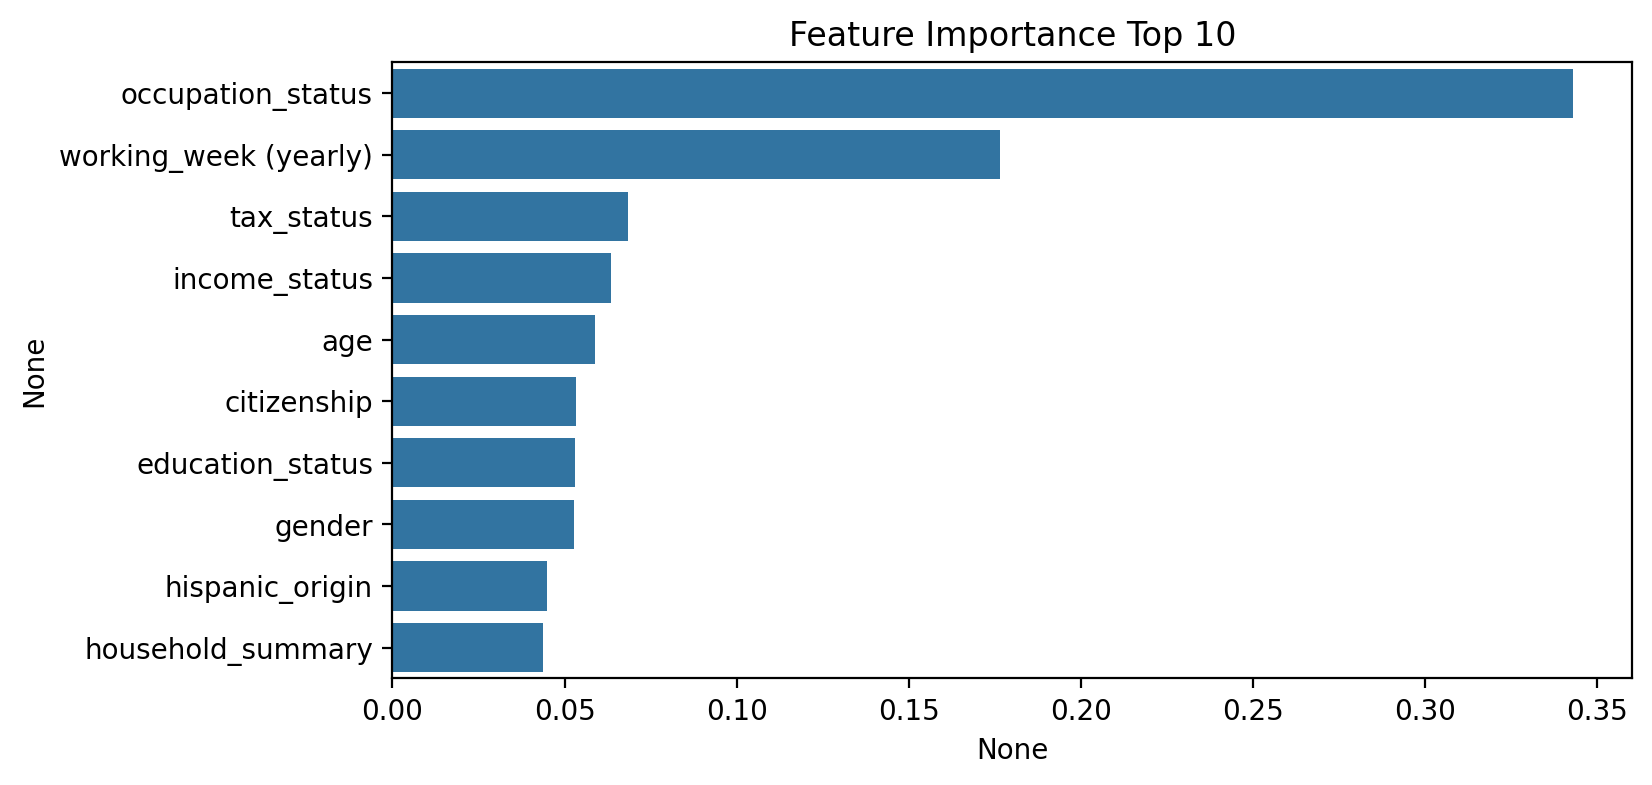

In [42]:
# feature importance 파악

# 배열형태로 반환
xgb_importance_values = xgb_optuna.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
xgb_series = pd.Series(xgb_importance_values, index = X_train.columns)
xgb_top10 = xgb_series.sort_values(ascending=False)[:10]

# 시각화
plt.figure(figsize=(8,4))
plt.title('Feature Importance Top 10')
sns.barplot(x=xgb_top10, y=xgb_top10.index)
plt.show()


# 이 지표는 절대적이지 않다.
# 중요도는 낮게 평가되었지만 실제로 중요한 특성일 수도 있고,
# 그렇기 때문에 제거했을 경우 성능이 떨어질 수도 있다.
# -> 상위 n개의 특성들을 제외한 나머지 특성들을 모두 제거하는 방식은 바람직하지 못함

# feature importance를 고려하여 특성별로 A/B test 를 진행하며 feature selection 해야 한다
# https://hwi-doc.tistory.com/entry/Feature-selection-feature-importance-vs-permutation-importance

In [43]:
y_test_xgb = xgb_optuna.predict(X_test)
y_test_xgb

array([  2.3565414,  -7.764872 , 441.7514   , ..., 569.9687   ,
        -1.1764423, 653.9405   ], dtype=float32)

In [48]:
submission_df_xgb = submission_df.copy()
submission_df_xgb["Income"] = y_test_xgb
submission_df_xgb.head()

,ID,Income
0,TEST_0000,2.356541
1,TEST_0001,-7.764872
2,TEST_0002,441.751404
3,TEST_0003,470.308014
4,TEST_0004,0.830236


In [49]:
# 전처리 완료한 파일 csv로 저장
submission_df_xgb.to_csv("data/submission_xgb2.csv", index=False)

### CatBoost

In [72]:
# optuna를 통해 생성한 하이퍼 파라미터로 조정하여, CatBoost 모델 생성
cat_features = X_train_no_enc.select_dtypes(exclude=np.number).columns.tolist()

X_train_pool = Pool(data=X_train_no_enc, label=y_train, cat_features=cat_features)
X_val_pool = Pool(data=X_val_no_enc, label=y_val, cat_features=cat_features)

cat_optuna.fit(X_train_pool, eval_set=X_val_pool, use_best_model=True)

0:	learn: 705.4830812	test: 690.3805666	best: 690.3805666 (0)	total: 44ms	remaining: 2m 16s
1:	learn: 704.8926974	test: 689.7828790	best: 689.7828790 (1)	total: 93.2ms	remaining: 2m 24s
2:	learn: 704.3292080	test: 689.1984410	best: 689.1984410 (2)	total: 136ms	remaining: 2m 21s
3:	learn: 703.7490389	test: 688.6023957	best: 688.6023957 (3)	total: 194ms	remaining: 2m 30s
4:	learn: 703.1817761	test: 688.0202740	best: 688.0202740 (4)	total: 310ms	remaining: 3m 12s
5:	learn: 702.6316092	test: 687.4416205	best: 687.4416205 (5)	total: 343ms	remaining: 2m 57s
6:	learn: 702.0760402	test: 686.8716942	best: 686.8716942 (6)	total: 400ms	remaining: 2m 57s
7:	learn: 701.5318562	test: 686.3099971	best: 686.3099971 (7)	total: 452ms	remaining: 2m 55s
8:	learn: 700.9977156	test: 685.7563847	best: 685.7563847 (8)	total: 482ms	remaining: 2m 45s
9:	learn: 700.4318158	test: 685.1908313	best: 685.1908313 (9)	total: 527ms	remaining: 2m 43s
10:	learn: 699.8717328	test: 684.6038565	best: 684.6038565 (10)	total:

In [73]:
# rmse_cat = metrics.mean_squared_error(y_val, cat_optuna.predict(X_val_no_enc),squared=False)
rmse_cat = metrics.mean_squared_error(y_val, cat_optuna.predict(X_val_no_enc),squared=False)
rmse_cat

593.4447132672911

In [74]:
rmse_cat = metrics.mean_squared_error(y_val, cat_optuna.predict(X_val_pool),squared=False)
rmse_cat

593.4447132672911

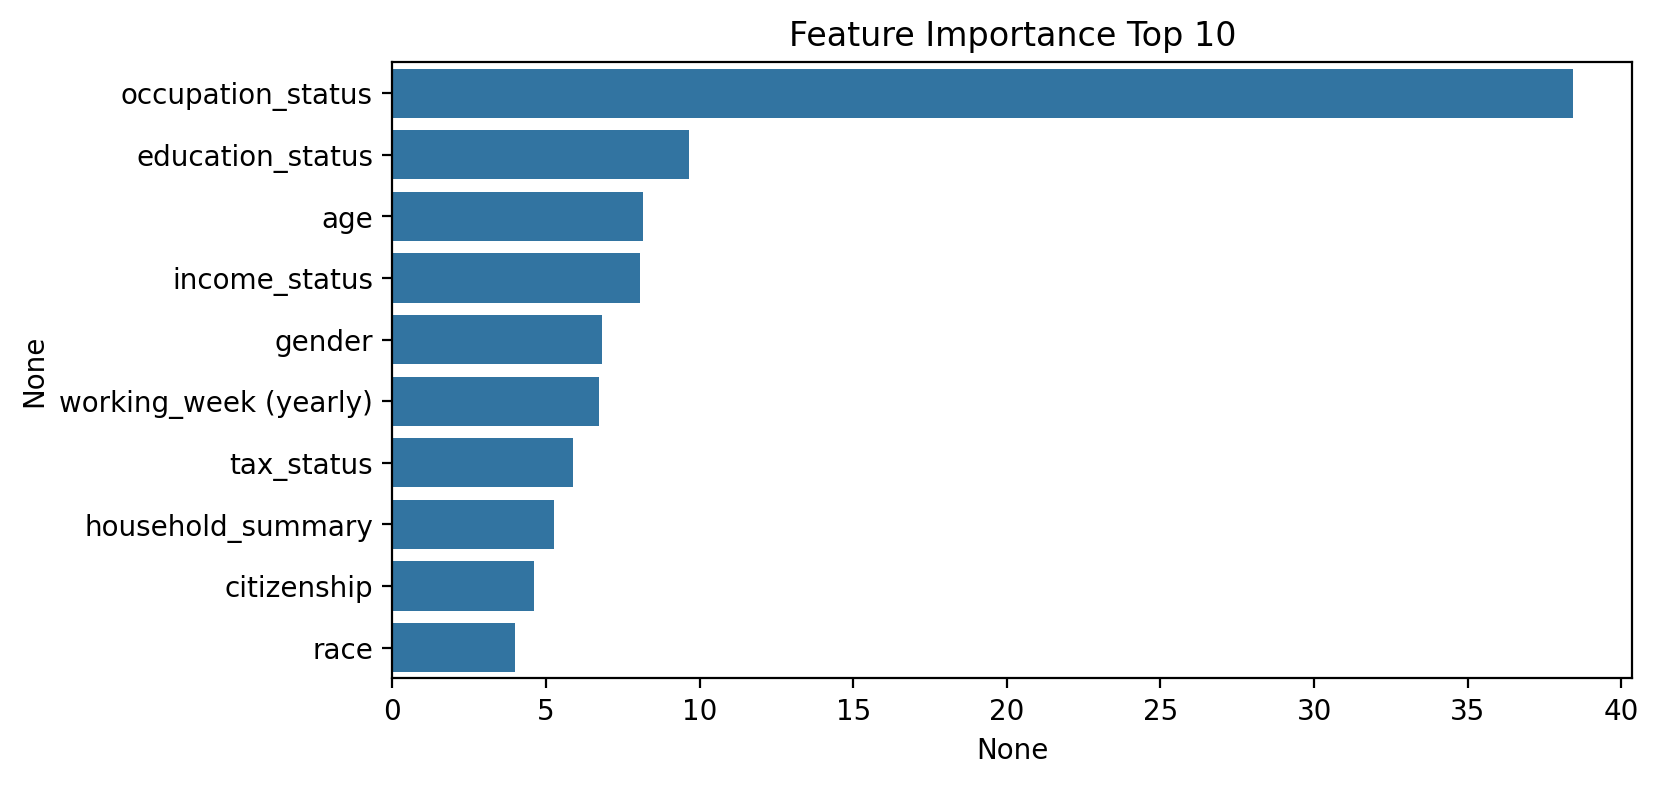

In [75]:
# feature importance 파악

# 배열형태로 반환
cat_importance_values = cat_optuna.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
cat_series = pd.Series(cat_importance_values, index = X_train.columns)
cat_top10 = cat_series.sort_values(ascending=False)[:10]

# 시각화
plt.figure(figsize=(8,4))
plt.title('Feature Importance Top 10')
sns.barplot(x=cat_top10, y=cat_top10.index)
plt.show()


# 이 지표는 절대적이지 않다.
# 중요도는 낮게 평가되었지만 실제로 중요한 특성일 수도 있고,
# 그렇기 때문에 제거했을 경우 성능이 떨어질 수도 있다.
# -> 상위 n개의 특성들을 제외한 나머지 특성들을 모두 제거하는 방식은 바람직하지 못함

# feature importance를 고려하여 특성별로 A/B test 를 진행하며 feature selection 해야 한다
# https://hwi-doc.tistory.com/entry/Feature-selection-feature-importance-vs-permutation-importance

In [76]:
y_test_cat = cat_optuna.predict(X_test_no_enc)
y_test_cat

array([-1.63998667e+01, -1.14191960e+01,  4.95491016e+02, ...,
        5.26504848e+02,  6.36017389e-01,  6.48395941e+02])

In [77]:
submission_df_cat = submission_df.copy()
submission_df_cat["Income"] = y_test_cat
submission_df_cat.head()

,ID,Income
0,TEST_0000,-16.399867
1,TEST_0001,-11.419196
2,TEST_0002,495.491016
3,TEST_0003,567.067043
4,TEST_0004,-3.982784


In [78]:
# 전처리 완료한 파일 csv로 저장
submission_df_cat.to_csv("data/submission_cat2.csv", index=False)

### LightGBM

In [66]:
lgbm_optuna.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 423
[LightGBM] [Info] Number of data points in the train set: 14000, number of used features: 11
[LightGBM] [Info] Start training from score 557.920714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

LGBMRegressor(colsample_bytree=0.43170716684320626,
              learning_rate=0.0011201643796082707, min_data_in_leaf=29,
              n_estimators=3601, num_leaves=184, subsample=0.2970900102311786)

In [67]:
rmse_lgbm = metrics.mean_squared_error(y_val, lgbm_optuna.predict(X_val),squared=False)
rmse_lgbm

[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


595.5469769077683

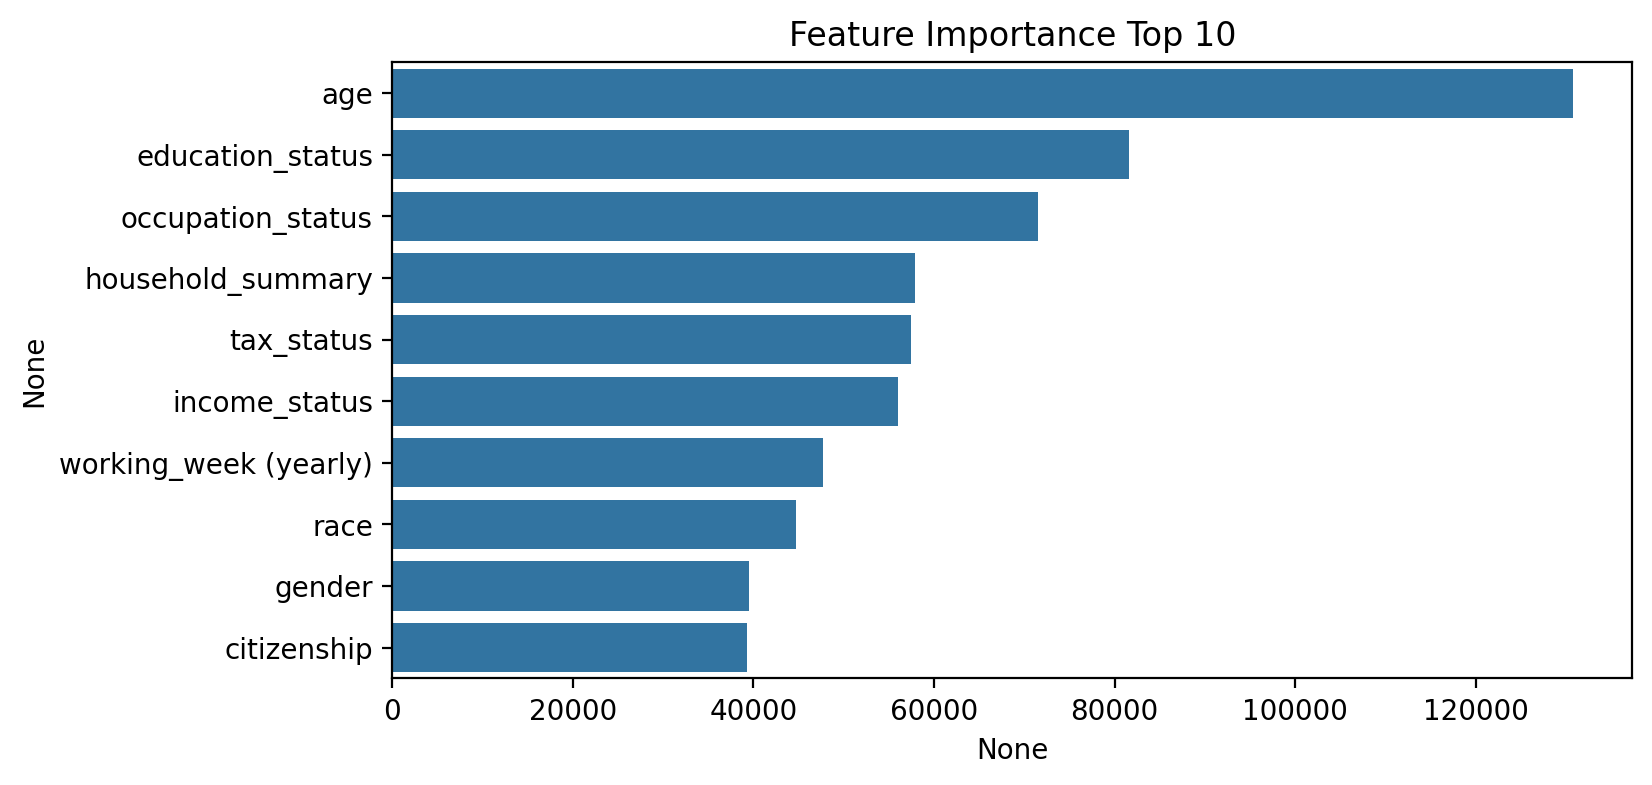

In [68]:
# feature importance 파악

# 배열형태로 반환
lgbm_importance_values = lgbm_optuna.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
lgbm_series = pd.Series(lgbm_importance_values, index = X_train.columns)
lgbm_top10 = lgbm_series.sort_values(ascending=False)[:10]

# 시각화
plt.figure(figsize=(8,4))
plt.title('Feature Importance Top 10')
sns.barplot(x=lgbm_top10, y=lgbm_top10.index)
plt.show()


# 이 지표는 절대적이지 않다.
# 중요도는 낮게 평가되었지만 실제로 중요한 특성일 수도 있고,
# 그렇기 때문에 제거했을 경우 성능이 떨어질 수도 있다.
# -> 상위 n개의 특성들을 제외한 나머지 특성들을 모두 제거하는 방식은 바람직하지 못함

# feature importance를 고려하여 특성별로 A/B test 를 진행하며 feature selection 해야 한다
# https://hwi-doc.tistory.com/entry/Feature-selection-feature-importance-vs-permutation-importance

In [69]:
y_test_lgbm = lgbm_optuna.predict(X_test)
y_test_lgbm

[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29


array([  9.8844104 ,  30.1587897 , 417.67577224, ..., 611.45595995,
         8.11456906, 557.77573985])

In [70]:
submission_df_lgbm = submission_df.copy()
submission_df_lgbm["Income"] = y_test_lgbm
submission_df.head()

,ID,Income
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,0


In [71]:
# 전처리 완료한 파일 csv로 저장
submission_df_lgbm.to_csv("data/submission_lgbm2.csv", index=False)